# Emittance minimization using Xopt with BAXGenerator running algorithm ScipyMinimizeEmittance
In this notebook we demonstrate the use of Xopt to perform Bayesian Algorithm Execution (BAX) as a means of minimizing the emittance described by a simple optical beam size model. BAX is a generalization of Bayesian Optimization that seeks to acquire observations that provide our model with maximal information about our property of interest. In this example, our property of interest is the minimal emittance and its location in tuning-parameter-space. See https://arxiv.org/pdf/2209.04587.pdf for details.

# Imports

In [1]:
# Ignore all warnings
import warnings
# warnings.filterwarnings("ignore")

import sys
# sys.path.append('C:\\Users\\Dylan\\SLAC') #parent directory containing emitopt module

import matplotlib.pyplot as plt
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import pandas as pd
import torch

from xopt import Xopt
from xopt.vocs import VOCS
from xopt.generators.bayesian.bax_generator import BaxGenerator

from xopt.evaluator import Evaluator

from emitopt.analysis import compute_emit_bmag
from emitopt.sampling import draw_product_kernel_post_paths
from emitopt.algorithms import GridMinimizeEmitBmag

import time
import numpy as np
import random

# Use CUDA if available

In [2]:
if torch.cuda.is_available():
# if False:
    torch.set_default_tensor_type('torch.cuda.DoubleTensor')
    tkwargs = {"dtype": torch.double, "device": "cuda"}
    use_cuda = True
    print('Using cuda.')
else:
    torch.set_default_tensor_type('torch.DoubleTensor')
    use_cuda = False

C:\Users\Dylan\AppData\Roaming\Python\Python39\site-packages\torch\__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\tensor\python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)


In [3]:
torch.cuda.is_available()

False

# Notebook settings

In [4]:
ndim = 2 #number of input dimensions
noise = False #whether to add noise to the ground-truth beam size function outputs
thick_quad = True
meas_dim = 1 #input dimension for measurement parameter
n_obs_init = 100 #number of random initial observations for GP model
n_samples = 20 #number of posterior samples for BAX
n_iter = 1 #number of optimization steps for Xopt to take (after acquiring random initial data)
rand_seed = 3

#random seeds for reproducibility 
torch.manual_seed(rand_seed)
np.random.seed(rand_seed) #only affects initial random observations through Xopt
random.seed(rand_seed)

# Build test function from single-quadrupole optical beam size model 
Here we define a simple ground-truth beam size function for our optimization problem, where we attempt to find the location in tuning parameter space with minimal emittance. Note that the function "test_func" used to evaluate the ground-truth beam size function takes a dictionary as input and returns a dictionary as the output.

In [5]:
from pyemittance.emittance_calc import EmitCalc
from pyemittance.load_json_configs import load_configs
from pyemittance.simulation import BeamSim

CONFIG = load_configs('LCLS2_OTR0H04')
CONFIG['beamline_info']

q_len = CONFIG['beamline_info']['Lquad']
rmat_x = torch.tensor(CONFIG['beamline_info']['rMatx']).reshape(2,2)
rmat_y = torch.tensor(CONFIG['beamline_info']['rMaty']).reshape(2,2)
print(rmat_x)
print(rmat_y)

tensor([[1.0000, 2.2000],
        [0.0000, 1.0000]])
tensor([[1.0000, 2.2000],
        [0.0000, 1.0000]])


In [6]:
BUNCH_PARAMS0 = {
    'total_charge': 50e-12,
    'norm_emit_x': 1e-6,
    'norm_emit_y': 2e-6,
    'beta_x': 10,
    'alpha_x': -1,
    'beta_y': 11,
    'alpha_y': -2,
    'energy': 80e6,
    'species':'electron'
}
sim = BeamSim(bunch_params=BUNCH_PARAMS0, beamline_info=CONFIG['beamline_info'])


# define variables functions
var_names = ['x' + str(i) for i in range(ndim)]
meas_param = var_names[meas_dim]

scale = 1.e3
def measure_beamsize(input_dict):
    x_tuning = torch.tensor([])
    for key in input_dict.keys():
        if key is not meas_param:
            x_tuning = torch.cat((x_tuning, torch.tensor([input_dict[key]])))
    rms_beamsizes0 = np.array(sim.beam_size_meas(input_dict[meas_param]))
    detuning_scale = 1. + 1*x_tuning.abs().sum().cpu()
    xrms, yrms = detuning_scale * rms_beamsizes0
    return {'xrms_sq': (float(xrms)*scale)**2.,
            'yrms_sq': (float(yrms)*scale)**2.} # mean-square beam sizes in mm squared

from emitopt.utils import get_quad_scale_factor
scale_factor = get_quad_scale_factor(E=.08, q_len=q_len)
# scale_factor = 1.
q = torch.linspace(-3,3,20)
bs = torch.tensor([np.array(sim.beam_size_meas(v))*scale for v in q.numpy()]).T
print(bs)
k = scale_factor*q
ks = torch.stack((k,-k))
rmats = torch.stack((rmat_x, rmat_y))
emit, bmag, sig, is_valid = compute_emit_bmag(ks, bs**2, q_len, rmats, thick=True)
print(emit[0], emit[1])
gt_emit_min = (emit[0]*emit[1]).sqrt()
def ground_truth_geometric_mean_emittance(emit_min, x_tuning):
    detuning_scale = 1. + x_tuning.abs().sum(dim=1)
    emit = emit_min * detuning_scale**2
    return emit

print('Ground truth minimum emit:', gt_emit_min)

tensor([[0.9752, 0.9042, 0.8337, 0.7634, 0.6936, 0.6241, 0.5550, 0.4864, 0.4182,
         0.3506, 0.2836, 0.2176, 0.1536, 0.0946, 0.0575, 0.0809, 0.1362, 0.1979,
         0.2613, 0.3252],
        [0.4155, 0.3205, 0.2269, 0.1385, 0.0781, 0.1120, 0.1969, 0.2917, 0.3896,
         0.4890, 0.5895, 0.6907, 0.7926, 0.8952, 0.9983, 1.1019, 1.2061, 1.3109,
         1.4161, 1.5219]])
tensor(0.0064) tensor(0.0128)
Ground truth minimum emit: tensor(0.0090)


C:\Users\Dylan\AppData\Local\Temp\ipykernel_6048\553575912.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:264.)
  bs = torch.tensor([np.array(sim.beam_size_meas(v))*scale for v in q.numpy()]).T


# Construct vocs

In [7]:
variables = {var_name: [-2,1] for var_name in var_names}
variables[meas_param] = [-3,3] #overwrite bounds for measurement parameter to capture minimum of single-quadrupole optical model

#construct vocs
vocs = VOCS(
    variables = variables,
    observables = ['xrms_sq', 'yrms_sq'],
)

print('variable_names =', vocs.variable_names)
print('meas_param =', "'" + meas_param + "'")
print('domain =\n', vocs.bounds.T)

variable_names = ['x0', 'x1']
meas_param = 'x1'
domain =
 [[-2.  1.]
 [-3.  3.]]


# Prepare generator options.
In this example, we use a specialty covariance module (Matern x Quadratic kernel) for our beam size model.

In [8]:
from gpytorch.kernels import MaternKernel, PolynomialKernel, ScaleKernel
from gpytorch.priors.torch_priors import GammaPrior

from xopt.generators.bayesian.models.standard import StandardModelConstructor
from xopt.generators.bayesian.bax_generator import BaxGenerator
from emitopt.algorithms import ScipyMinimizeEmittanceXY

# prepare custom covariance module
tuning_dims = list(range(vocs.n_variables))
tuning_dims.remove(meas_dim)
covar_module_x = (MaternKernel(ard_num_dims=len(tuning_dims), 
                              active_dims=tuning_dims, 
                              lengthscale_prior=None) * 
                              PolynomialKernel(power=2, active_dims=[meas_dim])
                 )

scaled_covar_module_x = ScaleKernel(covar_module_x)#, outputscale_prior=GammaPrior(2.0, 0.15))
covar_module_y = (MaternKernel(ard_num_dims=len(tuning_dims), 
                              active_dims=tuning_dims, 
                              lengthscale_prior=None) * 
                              PolynomialKernel(power=2, active_dims=[meas_dim])
                 )
scaled_covar_module_y =  ScaleKernel(covar_module_y)#, outputscale_prior=GammaPrior(2.0, 0.15))

# prepare options for Xopt generator
covar_module_dict = {'xrms_sq': scaled_covar_module_x,
                     'yrms_sq': scaled_covar_module_y}

model_constructor = StandardModelConstructor(covar_modules=covar_module_dict, use_low_noise_prior=True)

In [9]:
from xopt.numerical_optimizer import LBFGSOptimizer, GridOptimizer
numerical_optimizer = LBFGSOptimizer(
                                    n_restarts=20,
                                    max_time=2)
# numerical_optimizer = GridOptimizer()

# Construct generator, evaluator, Xopt objects

In [10]:
#Prepare Algorithm
algo_kwargs = {
        'x_key': 'xrms_sq',
        'y_key': 'yrms_sq',
        'scale_factor': scale_factor,
        'q_len': q_len,
        'rmat_x': rmat_x,
        'rmat_y': rmat_y,
        'twiss0_x': torch.tensor([10., -1.]),
        'twiss0_y': torch.tensor([11., -2.]),
        'n_samples': n_samples,
        'meas_dim': meas_dim,
        'n_steps_measurement_param': 20,
        'thick_quad': thick_quad,
        'n_grid_points': 15
}
algo = GridMinimizeEmitBmag(**algo_kwargs)
# algo = ScipyMinimizeEmittanceXY(**algo_kwargs)

#construct BAX generator
generator = BaxGenerator(vocs=vocs, 
                         gp_constructor=model_constructor, 
                         numerical_optimizer=numerical_optimizer,
                         algorithm=algo, 
                         use_cuda=use_cuda)

#construct evaluator
evaluator = Evaluator(function=measure_beamsize)

#construct Xopt optimizer
optimizer = Xopt(evaluator=evaluator, generator=generator, vocs=vocs)

# Optimize

In [11]:
# call X.random_evaluate() to generate random initial points and evaluate on test_func
optimizer.random_evaluate(n_obs_init)

,x0,x1,xrms_sq,yrms_sq,xopt_runtime,xopt_error
0,-0.652394,1.847566,0.026672,3.538606,0.008864,False
1,-1.124443,-1.354018,1.676228,0.074184,0.000312,False
2,0.127286,-1.709620,0.600795,0.007479,0.000201,False
3,-0.532483,-2.832590,2.064212,0.313026,0.000192,False
4,-1.678841,-2.105829,4.312917,0.167121,0.000187,False
...,...,...,...,...,...,...
95,-1.741926,2.555773,0.416634,14.178267,0.000180,False
96,-0.900997,0.126507,0.304362,1.213422,0.000180,False
97,-0.097822,2.626323,0.075093,2.351463,0.000174,False
98,-0.658534,-2.305449,1.847912,0.119736,0.000178,False


C:\Users\Dylan\anaconda3\envs\xopt-dev\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
C:\Users\Dylan\anaconda3\envs\xopt-dev\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


(<Figure size 800x990 with 11 Axes>,
 array([[<AxesSubplot: title={'center': 'Posterior Mean [xrms_sq]'}, ylabel='x1'>,
         <AxesSubplot: title={'center': 'Posterior SD [xrms_sq]'}>],
        [<AxesSubplot: title={'center': 'Posterior Mean [yrms_sq]'}, ylabel='x1'>,
         <AxesSubplot: title={'center': 'Posterior SD [yrms_sq]'}>],
        [<AxesSubplot: title={'center': 'Acq. Function'}, xlabel='x0', ylabel='x1'>,
         <AxesSubplot: xlabel='x0'>]], dtype=object))

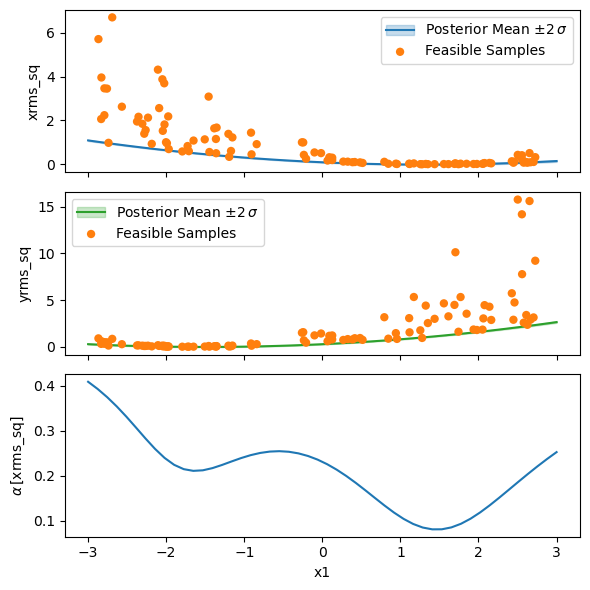

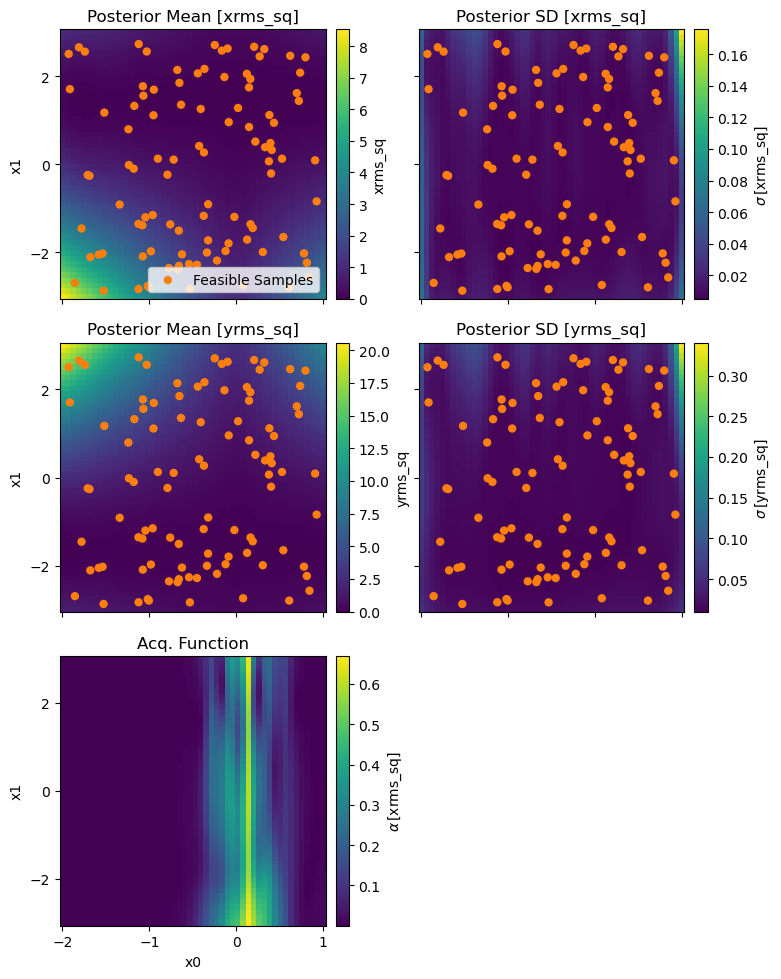

In [12]:
from xopt.generators.bayesian.visualize import visualize_generator_model
optimizer.generator.train_model()
visualize_generator_model(optimizer.generator, variable_names=['x1'], reference_point={'x0':torch.tensor([0.])})
visualize_generator_model(optimizer.generator, variable_names=['x0','x1'], reference_point={'x1':torch.tensor([0.]), 'x0':torch.tensor([0.])})

(<Figure size 400x370 with 1 Axes>,
 <AxesSubplot: xlabel='x0', ylabel='Virtual Objective'>)

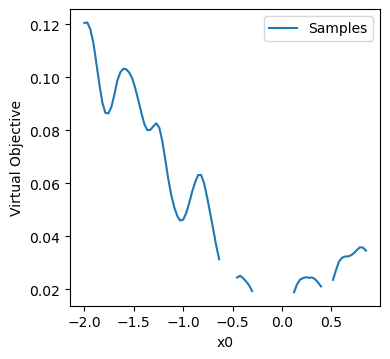

In [23]:
from xopt.generators.bayesian.bax.visualize import visualize_virtual_objective
visualize_virtual_objective(optimizer.generator, 
                            variable_names=['x0'],
                            reference_point={'x0':torch.tensor([0.]), 
                                             'x1':torch.tensor([0.])}, 
                            n_grid=100, 
                            n_samples=1,
                            show_samples=True)
# visualize_virtual_objective(optimizer.generator, variable_names=['x0','x1'],reference_point={'x0':torch.tensor([0.]), 'x1':torch.tensor([0.])}, n_grid=10, n_samples=1000)

In [ ]:
results = []

In [ ]:
# plt.hist(emits_at_target_valid.flatten().cpu(), density=True)
# plt.xlabel('Predicted Optimal Emittance')
# plt.ylabel('Probability Density')
# plt.show()
# print('sample validity rate:', svr)

for i in range(1, n_iter+1):

    print('Iteration:', i, '/', n_iter)

    start = time.time()

    # call X.step() to generate a random initial point and evaluate on test_func
    optimizer.step()    

    
    #extract GP models
    model = optimizer.generator.train_model()
    bax_model_ids = [optimizer.generator.vocs.output_names.index(name)
                            for name in optimizer.generator.algorithm.observable_names_ordered]
    bax_model = model.subset_output(bax_model_ids)
    beam_size_model_x = bax_model.models[0]
    beam_size_model_y = bax_model.models[1]
    
    #extract and store algorithm results for this iteration
    results += [optimizer.generator.algorithm_results]
#     beam_size_models[i] = beam_size_model
    
    #get mean-predicted optimal tuning config and eval predicted emits at this location in tuning parameter space
    algo = optimizer.generator.algorithm
#     X_tuned, emits_at_target_valid, svr = algo.mean_output(beam_size_model,
#                                                          torch.tensor(vocs.bounds),
#                                                          num_restarts=10)
    
    end = time.time()
    print('This iteration took:', end-start, 'seconds.\n')

#     if i % 5 == 0:
#         plt.hist(emits_at_target_valid.flatten().cpu(), density=True)
#         plt.xlabel('Predicted Optimal Emittance')
#         plt.ylabel('Probability Density')
#         plt.show()
#         print('sample validity rate:', svr)

In [ ]:
optimizer.generator.train_model()

visualize_virtual_objective(optimizer.generator, 
                            variable_names=['x0'],
                            reference_point={'x0':torch.tensor([0.]), 'x1':torch.tensor([0.])}, 
                            n_grid=50, 
                            n_samples=100,
                           show_samples=True)
# visualize_virtual_objective(optimizer.generator, 
#                             variable_names=['x0','x1'],
#                             reference_point={'x0':torch.tensor([0.]), 'x1':torch.tensor([0.])}, 
#                             n_grid=10, 
#                             n_samples=1000)

In [ ]:
from emitopt.visualize import plot_sample_optima_convergence_inputs
fig, axs = plot_sample_optima_convergence_inputs(optimizer.generator, results, show_valid_only=False)
# for ax in axs:
#     ax.axhline(0, ls='--', c='k')

In [ ]:
from emitopt.visualize import plot_sample_optima_convergence_emits
fig, ax = plot_sample_optima_convergence_emits(results)
ax.axhline(gt_emit_min, ls='--', c='k', label='ground truth')

In [ ]:
from emitopt.utils import x_tuning_to_dict, get_bax_optimum
print(optimizer.generator.algorithm_results['x_tuning_best'])
x_tuning_best = optimizer.generator.algorithm_results['x_tuning_best'].mean(dim=0)
print(x_tuning_best)
reference_point = get_bax_optimum(optimizer.generator)
print(reference_point)
target_point = x_tuning_to_dict(optimizer.generator, x_tuning = torch.tensor([[0,0]]))
print(target_point)

In [ ]:
from emitopt.visualize import plot_virtual_measurement_scan
fig, ax, best_q = plot_virtual_measurement_scan(optimizer, reference_point, n_samples=10)
ax[0].set_ylim(top=1)
ax[1].set_ylim(top=3, bottom=0.9)
ax[0].axhline(0, c='k')

In [ ]:
from emitopt.visualize import plot_acq_func_opt_results
plot_acq_func_opt_results(optimizer)